In [31]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import regex as re

In [2]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

device(type='mps')

In [3]:
do_download:bool=False
if do_download:
    !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [4]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

## Different methods to compute rolling mean on T axis.
like weighted sum with same weight on previous items of sequence

In [5]:
# method 1
xbow = torch.zeros((B, T, C))
xbow.shape
for b in range(B):
    for t in range(T):
        xprev = x[b, : t + 1]
        # print(b, t, xprev.shape)
        xbow[b, t] = torch.mean(xprev, 0)
        # print("-----")
        # print(xbow)

xbow.shape

torch.Size([4, 8, 2])

In [6]:
# method 2
wei = torch.tril(torch.ones((T, T)))
# print(wei)
wei = wei / wei.sum(axis=1, keepdim=True)
print("weight", wei)
xbow2 = wei @ x  # B,T,C @ B,T,T ---> B,T,C
torch.allclose(xbow, xbow2)

weight tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


True

In [7]:
# method 3 using softmax
tril = torch.tril(torch.ones((T, T)))
wei = torch.zeros((T, T))
# print(wei)
wei = wei.masked_fill(tril == 0, value=float("-inf"))
# print(wei)
wei = F.softmax(wei, dim=1)
print("weight", wei)

xbow3 = wei @ x
torch.allclose(xbow, xbow3)

weight tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


True

# model

In [8]:
with open("./input.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [9]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {s: i for i, s in enumerate(chars)}
itos = {i: s for i, s in enumerate(chars)}


def encode(s: str) -> list[int]:
    return [stoi[c] for c in s]


def decode(l: list[int]) -> str:
    return "".join([itos[i] for i in l])

In [10]:
decode(encode("j'aime les chats"))
# stoi["a"], stoi["A"]

"j'aime les chats"

In [11]:
torch.manual_seed(42)
# Compute train and validation data
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(text))
train = data[:n]
val = data[n:]


def get_batch(split: str = "train", batch_size: int = 16, block_size: int = 8):
    data = train if split == "train" else val
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # ix are random starting points of each batch
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

In [12]:
x, y = get_batch(batch_size=16, block_size=8)
x, y
x.shape, y.shape

(torch.Size([16, 8]), torch.Size([16, 8]))

In [13]:
torch.manual_seed(42)
B, T, C = 16, 8, 32
x = torch.rand(B, T, C)

head_size = 32
key = nn.Linear(C, head_size)
k = key(x)
query = nn.Linear(C, head_size)
q = query(x)
value = nn.Linear(C, head_size)
v = value(x)

wei = q @ k.transpose(-2, -1) * head_size**-0.5
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=-1)

out = wei @ v
# out.shape

In [14]:
# test with a hard coded query and key
q = torch.tensor([[[0.0, 1.0], [2.0, 3.0], [4.0, 5.0]]])
k = torch.tensor([[[0.0, 1.0], [2.0, 3.0], [4.0, 5.0]]])
B, T, C = q.shape
q.shape
wei = q @ k.transpose(-2, -1)  # * head_size**-0.5
tril = torch.tril(torch.ones(T, T))
# wei = wei.masked_fill(tril == 0, float("-inf"))
# wei = F.softmax(wei, dim=-1)
wei

tensor([[[ 1.,  3.,  5.],
         [ 3., 13., 23.],
         [ 5., 23., 41.]]])

In [47]:
def pre_tokenize(s: str) -> list[str]:
    """Pre-tokenize a string to be compatible with GPT2 tokenizer. It creates a list of tokens where each token starts with a space special char Ġ.

    Arguments:
        s -- string to tokeninze

    Returns:
        list of tokens
    """
    raw_tokens = [t for t in re.split(r"(\s|,|\.|;|:|!|\?|\t)", s) if t]
    tokens = []
    prev_t = None
    for t in raw_tokens:
        if t == " ":
            t = "Ġ"
        if prev_t == "Ġ" and t != "Ġ":
            t = prev_t + t
            tokens.pop()  # remove previous token because we merge it (blank) with current token
        tokens.append(t)
        prev_t = t

    return tokens


def pre_decode(tokens: list[str]) -> str:
    return "".join([t.replace("Ġ", " ") for t in tokens])


pre_decode(pre_tokenize("hello  world, how are you?"))

'hello  world, how are you?'

In [ ]:
class BPETokenizer:
    
    def __init__(self, vocab_size:int=200)
        self.vocab_size = vocab_size
        self.itov = {}
        self.vtoi = {}
        self.alphabet:list[str]=[]
        
    def fit(self, text:str):
        chars = sorted(list(set(text)))
        self.alphabet = ["<|OOV|>", "<|EOT|>"]+chars  

    
    

In [15]:
# hyperparams
batch_size = 16  # how many independent sequences will we process in parallel?
block_size = 8  # what is the maximum context length for predictions?

vocab_size = 65
n_embd = 32
num_heads = 4

In [16]:
class Head(nn.Module):
    def __init__(self, head_size: int, n_embd: int, block_size: int) -> None:
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.smax = nn.Softmax(dim=-1)
        self.register_buffer("tril", tensor=torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = self.smax(wei)  # F.softmax(wei, dim=-1)
        v = self.value(x)
        out = wei @ v
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, head_size: int, block_size: int, n_embd: int) -> None:
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, block_size=block_size, n_embd=n_embd) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out


class FeedForward(nn.Module):
    def __init__(self, n_embd: int) -> None:
        super().__init__()
        self.net = nn.Sequential(nn.Linear(n_embd, 4 * n_embd), nn.ReLU(), nn.Linear(4 * n_embd, n_embd))

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embd: int, num_heads: int, block_size: int):
        super().__init__()
        head_size = n_embd // num_heads
        self.sa = MultiHeadAttention(num_heads=num_heads, head_size=head_size, block_size=block_size, n_embd=n_embd)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        x = x + self.sa(x)
        x = x + self.ffwd(x)
        return x


class BigramModel(nn.Module):
    def __init__(self, vocab_size: int, num_heads: int = 4, n_embd: int = 32, block_size: int = 8) -> None:
        super().__init__()
        self.num_heads = num_heads
        self.block_size = block_size
        self.n_embd = n_embd
        self.token_emb = torch.nn.Embedding(vocab_size, n_embd)
        self.pos_emb = torch.nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, num_heads, block_size),
            Block(n_embd, num_heads, block_size),
            Block(n_embd, num_heads, block_size),
            Block(n_embd, num_heads, block_size),
        )
        self.lm_head = torch.nn.Linear(n_embd, vocab_size)
        # self.lm_head = Head(head_size=1)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos_emb = self.pos_emb(torch.arange(T, device=device))
        # print("pos_emb shape", pos_emb.shape)
        x = tok_emb + pos_emb  # B, T, C
        # print(f"x shape: {x.shape}")
        x = self.blocks(x)
        logits = self.lm_head(x)

        # print(f"logits shape: {logits.shape}")
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size :]
            logits, _ = self(idx_cond)
            # print("generate logit shape", logits.shape)

            logits = logits[:, -1, :]

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


model = BigramModel(vocab_size, num_heads=num_heads, n_embd=n_embd, block_size=block_size)
model = model.to(device)
xb, yb = get_batch("train")
train_logit, train_loss = model(xb)

In [17]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


max_iters = 5001
eval_iters = 200
eval_interval = 500
learning_rate = 1e-3


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

model_id = "cop_gpt"
model_version = "0.1"
log_dir = Path("../runs") / f"{model_id}-{model_version}" / f"{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"

writer = SummaryWriter(log_dir=log_dir)

for i in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if i % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        writer.add_scalar("loss/train", losses["train"], i)
        writer.add_scalar("loss/val", losses["val"], i)

    # sample a batch of data
    xb, yb = get_batch("train")

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    for name, weight in model.named_parameters():
        writer.add_histogram(name, weight, i)

    optimizer.step()

step 0: train loss 4.7607, val loss 4.7535
step 500: train loss 2.4672, val loss 2.4884
step 1000: train loss 2.3331, val loss 2.3338
step 1500: train loss 2.2356, val loss 2.2469
step 2000: train loss 2.2100, val loss 2.2634
step 2500: train loss 2.1477, val loss 2.2093
step 3000: train loss 2.1221, val loss 2.1764
step 3500: train loss 2.1036, val loss 2.1588
step 4000: train loss 2.0798, val loss 2.1432
step 4500: train loss 2.0451, val loss 2.1230
step 5000: train loss 2.0197, val loss 2.1211


In [19]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=200)[0].tolist()))


Shald my sive thy;
I ham scerawe,
Derst. Your hall yem ance pine lives shall to dids we and
so tays sourls,
No.

NIRESAM By tids,
Am grock confids it thears
An me knothg and to
That dead by be dam, er


In [20]:
embeddings = model.state_dict()["token_emb.weight"]
metadata = [itos[i] for i in range(vocab_size)]


# Add embeddings to the writer
writer.add_embedding(embeddings, metadata=metadata)

# Close the writer
writer.close()

## Understand model behaviour

Capture the activation at various moment within the model

In [20]:
model.blocks

Sequential(
  (0): Block(
    (sa): MultiHeadAttention(
      (heads): ModuleList(
        (0-3): 4 x Head(
          (key): Linear(in_features=32, out_features=8, bias=False)
          (query): Linear(in_features=32, out_features=8, bias=False)
          (value): Linear(in_features=32, out_features=8, bias=False)
          (smax): Softmax(dim=-1)
        )
      )
      (proj): Linear(in_features=32, out_features=32, bias=True)
    )
    (ffwd): FeedForward(
      (net): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=32, bias=True)
      )
    )
  )
  (1): Block(
    (sa): MultiHeadAttention(
      (heads): ModuleList(
        (0-3): 4 x Head(
          (key): Linear(in_features=32, out_features=8, bias=False)
          (query): Linear(in_features=32, out_features=8, bias=False)
          (value): Linear(in_features=32, out_features=8, bias=False)
          (smax): Softmax(dim=-1)
     

In [21]:
activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


# register a hook to access activations of each head.
for b, block in enumerate(model.blocks):
    for i, h in enumerate(block.sa.heads):
        h.register_forward_hook(get_activation(f"block_{b}_head_{i}"))
        h.smax.register_forward_hook(get_activation(f"block_{b}_smax_{i}"))

model.lm_head.register_forward_hook(get_activation("lm_head"))

In [27]:
gen_toks = model.generate(context, max_new_tokens=8)
chars = [c for c in decode(gen_toks[0].tolist())]
chars

['\n', 'C', 'a', 'i', 'n', 'd', ' ', 't', 'h']

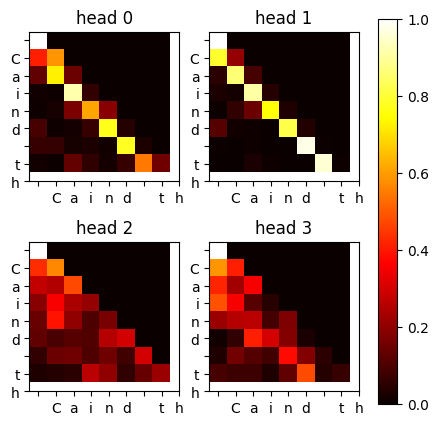

In [30]:
num_rows = num_heads // 2
num_cols = num_heads // 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
axes = axes.flatten()


for i, ax in enumerate(axes):
    im = ax.imshow(activation[f"block_0_smax_{i}"][0].cpu().numpy(), cmap="hot", interpolation="nearest")
    ax.set_title(f"head {i}")
    ax.set_xticks(np.arange(len(chars)), labels=chars)
    ax.set_yticks(np.arange(len(chars)), labels=chars)

cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.1, pad=0.05)


# fig.colorbar(im, ax=ax)
# fig.tight_layout()

In [24]:
# plot histogramt (torch.histogram) for each output  distribution for each layer. Also plot gradient to check its normally distributed.
for l in model.blocks[0].sa.heads.named_parameters():
    print(l[0], l[1].shape)

0.key.weight torch.Size([8, 32])
0.query.weight torch.Size([8, 32])
0.value.weight torch.Size([8, 32])
1.key.weight torch.Size([8, 32])
1.query.weight torch.Size([8, 32])
1.value.weight torch.Size([8, 32])
2.key.weight torch.Size([8, 32])
2.query.weight torch.Size([8, 32])
2.value.weight torch.Size([8, 32])
3.key.weight torch.Size([8, 32])
3.query.weight torch.Size([8, 32])
3.value.weight torch.Size([8, 32])


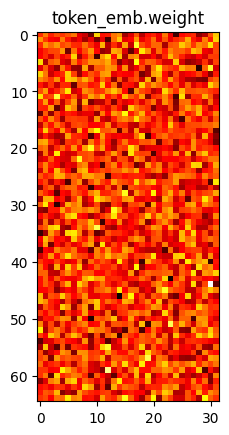

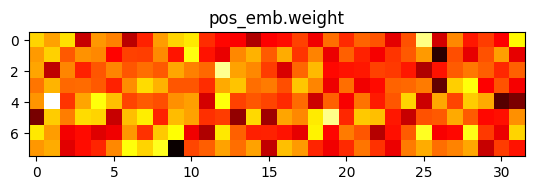

In [25]:
def display_params(model, layer_name):
    npp = model.state_dict()[layer_name].cpu().detach().numpy()

    plt.imshow(npp, cmap="hot", interpolation="nearest")
    plt.title(layer_name)
    plt.show()


display_params(model, "token_emb.weight")
display_params(model, "pos_emb.weight")

### view layer values

In [26]:
Add mechanism to view attention on each token
https://www.comet.com/site/blog/explainable-ai-for-transformers/

SyntaxError: invalid syntax (1072698059.py, line 1)